In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [4]:
!wget $data

--2025-10-15 16:57:11--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.001s  

2025-10-15 16:57:12 (107 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [2]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']

numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [5]:
df[categorical_features] = df[categorical_features].fillna("NA")
df[numerical_features] = df[numerical_features].fillna(0.0)

In [6]:
df_full_train, df_test = train_test_split(df, test_size= 0.2, random_state= 1)
df_train, df_val = train_test_split(df_full_train, test_size= 0.25, random_state= 1)


In [7]:
df_train = df_train.reset_index(drop= True)
df_test = df_test.reset_index(drop= True)
df_val = df_val.reset_index(drop= True)

y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values

del df_train["converted"]
del df_test["converted"]
del df_val["converted"]

In [19]:
auc_scores = {}

for var in numerical_features:
    auc = roc_auc_score(y_train, df_train[var])
    
    # If AUC < 0.5, invert the feature direction
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
        
    auc_scores[var] = auc

# Sort by AUC descending
sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)

for var, auc in sorted_auc:
    print(f"{var}: {auc:.3f}")


number_of_courses_viewed: 0.748
interaction_count: 0.718
lead_score: 0.617
annual_income: 0.550


In [9]:
train_dict = df_train[categorical_features + numerical_features].to_dict(orient= "records")

dv = DictVectorizer(sparse= False)

X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_features + numerical_features].to_dict(orient= "records")
X_val = dv.transform(val_dict)


In [10]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [11]:
y_pred = model.predict_proba(X_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)


0.817

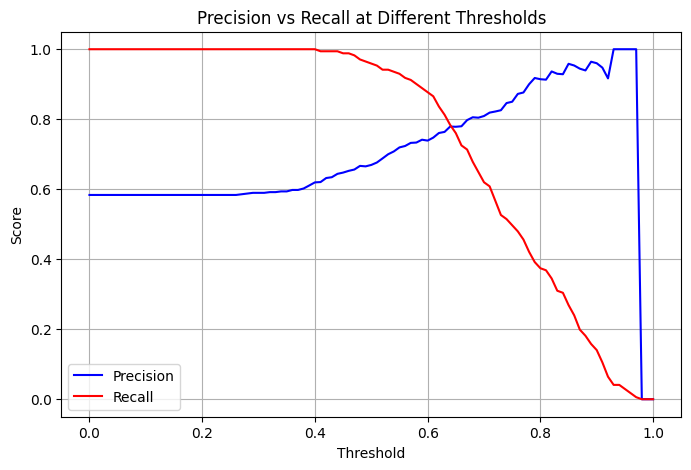

Precision and recall intersect at threshold ≈ 0.980


In [12]:

# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Compute precision and recall for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division= 0))
    recalls.append(recall_score(y_val, preds, zero_division= 0))

# Plot precision and recall curves
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Find intersection threshold (closest point where precision ≈ recall)
diff = np.abs(np.array(precisions) - np.array(recalls))
intersect_idx = np.argmin(diff)
intersect_threshold = thresholds[intersect_idx]

print(f"Precision and recall intersect at threshold ≈ {intersect_threshold:.3f}")


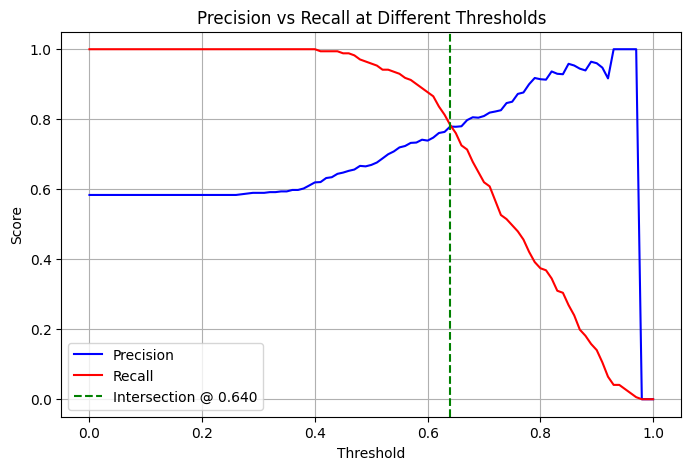

First meaningful intersection at threshold ≈ 0.640


In [13]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions, recalls = [], []

# Compute precision and recall for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division= 0))
    recalls.append(recall_score(y_val, preds, zero_division= 0))

precisions = np.array(precisions)
recalls = np.array(recalls)

# Find all intersections (where sign of precision - recall changes)
diff = precisions - recalls
cross_idxs = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) <= 0)[0]

if len(cross_idxs) > 0:
    # Take the first crossing as the "meaningful" one
    first_cross = cross_idxs[0]
    intersect_threshold = thresholds[first_cross]
else:
    intersect_threshold = None

# Plot precision and recall
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
if intersect_threshold is not None:
    plt.axvline(intersect_threshold, color='green', linestyle='--', label=f'Intersection @ {intersect_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

if intersect_threshold is not None:
    print(f"First meaningful intersection at threshold ≈ {intersect_threshold:.3f}")
else:
    print("No intersection found within threshold range.")


In [14]:
# Get predicted probabilities for the positive class
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Define thresholds
thresholds = np.arange(0.0, 1.01, 0.01)

precisions, recalls, f1_scores = [], [], []

# Compute precision, recall, and F1 for each threshold
for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    P = precision_score(y_val, preds, zero_division= 0)
    R = recall_score(y_val, preds, zero_division= 0)
    if (P + R) == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)
    precisions.append(P)
    recalls.append(R)
    f1_scores.append(f1)

# Find the threshold with the maximum F1 score
max_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_idx]
best_f1 = f1_scores[max_f1_idx]

print(f"Maximum F1 score = {best_f1:.3f} at threshold ≈ {best_threshold:.3f}")


Maximum F1 score = 0.812 at threshold ≈ 0.570


In [15]:
# Prepare KFold
n_splits = 5
kfold = KFold(n_splits= 5, shuffle=True, random_state=1)

# Store AUC results
scores = []

# Loop over folds
for train_idx, val_idx in tqdm(kfold.split(df_full_train), total = n_splits):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    # ✅ Corrected assignments
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    # Convert categorical & numerical features to dicts for DictVectorizer
    train_dict = df_train[categorical_features + numerical_features].to_dict(orient="records")
    val_dict = df_val[categorical_features + numerical_features].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)
    
    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Evaluate AUC on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
    print(f"AUC on fold: {auc:.3f}")

# Compute mean and std of AUCs
mean_auc = np.mean(scores)
std_auc = np.std(scores)

print("\nCross-validation results")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Std AUC:  {std_auc:.4f}")


100%|██████████| 5/5 [00:00<00:00, 61.54it/s]

AUC on fold: 0.806
AUC on fold: 0.871
AUC on fold: 0.775
AUC on fold: 0.802
AUC on fold: 0.856

Cross-validation results
Mean AUC: 0.822
Std AUC:  0.0358


In [16]:
# Prepare
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
C_values = [0.000001, 0.001, 1]
results = []

for C in tqdm(C_values, desc="Hyperparameter tuning"):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        train_dict = df_train[categorical_features + numerical_features].to_dict(orient="records")
        val_dict = df_val[categorical_features + numerical_features].to_dict(orient="records")
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = round(np.mean(scores), 3)
    std_auc = round(np.std(scores), 3)
    results.append((C, mean_auc, std_auc))
    print(f"C={C} -> Mean AUC: {mean_auc:.3f}, Std: {std_auc:.3f}")

# Display results
print("\nCross-validation summary:")
for r in results:
    print(f"C={r[0]}: Mean AUC={r[1]}, Std={r[2]}")

# Select best C
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results_sorted[0][0]
print(f"\nBest C = {best_C}")


Hyperparameter tuning: 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

C=1e-06 -> Mean AUC: 0.560, Std: 0.024
C=0.001 -> Mean AUC: 0.867, Std: 0.029
C=1 -> Mean AUC: 0.822, Std: 0.036

Cross-validation summary:
C=1e-06: Mean AUC=0.56, Std=0.024
C=0.001: Mean AUC=0.867, Std=0.029
C=1: Mean AUC=0.822, Std=0.036

Best C = 0.001
